In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as plt
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageOps
from scipy.ndimage import map_coordinates, gaussian_filter
from collections import defaultdict
import shutil
import uuid

%run '/kaggle/input/cte-moreparams/Transformer_CustomEncoder_final_pe_modecombinedpart2.ipynb'
%run '/kaggle/input/icdar17-lsegs-hybridtr-model/dataloader_ICDAR17_lsegs.ipynb'


import numpy as np
import os

torch.Size([1, 105])


In [2]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def download_cerug(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)


In [3]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        self.writer_images = self.organize_by_writer(self.imglist)
       

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def organize_by_writer(self, imglist):
        writer_images = defaultdict(list)
        for img in imglist:
            writer_id = img.split('-')[0]
            writer_images[writer_id].append(img)
        return writer_images

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def add_noise(self, image):
        image_array = np.array(image)
        noise = np.random.normal(0, 25, image_array.shape).astype(np.int8)
        noisy_image = image_array + noise
        noisy_image = np.clip(noisy_image, 0, 255)
        return Image.fromarray(noisy_image).convert('L')

    def save_image(self, image, filename):
        image.save(os.path.join(self.folder, filename))

    def augment_and_balance(self):
        for writer_id, images in self.writer_images.items():
            if len(images) < 150:
                additional_images = []
                for imgfile in images:
                    image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
                    original_image = np.array(image)

                    # Elastic distortion
                    elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
                    elastic_image = Image.fromarray(elastic_image).convert('L')
                    elastic_image_filename = imgfile.split('.')[0] + '_elastic.' + self.imgtype
                    self.save_image(elastic_image, elastic_image_filename)
                    additional_images.append(elastic_image_filename)

                    # Perspective transformation
                    perspective_image = self.perspective_transform(image)
                    perspective_image_filename = imgfile.split('.')[0] + '_perspective.' + self.imgtype
                    self.save_image(perspective_image, perspective_image_filename)
                    additional_images.append(perspective_image_filename)

                    # Add noise
                    noisy_image = self.add_noise(image)
                    noisy_image_filename = imgfile.split('.')[0] + '_noisy.' + self.imgtype
                    self.save_image(noisy_image, noisy_image_filename)
                    additional_images.append(noisy_image_filename)

                # Update the writer's image list with new augmented images
                self.writer_images[writer_id].extend(additional_images)

                # Bootstrap if necessary
                while len(self.writer_images[writer_id]) < 150:
                    bootstrap_images = random.choices(self.writer_images[writer_id], k=150 - len(self.writer_images[writer_id]))
                    for idx, imgfile in enumerate(bootstrap_images):
                        img = Image.open(os.path.join(self.folder, imgfile)).convert('L')
                        iteration_number = len(self.writer_images[writer_id]) + idx + 1
                        bootstrap_image_filename = f"{imgfile.split('.')[0]}_b{iteration_number}.{self.imgtype}"
                        self.save_image(img, bootstrap_image_filename)
                        self.writer_images[writer_id].append(bootstrap_image_filename)

            # Undersample if necessary
            if len(self.writer_images[writer_id]) > 150:
                self.writer_images[writer_id] = random.sample(self.writer_images[writer_id], 150)
    
    def delete_images(self):
        all_images = os.listdir(self.folder)
        images_to_keep = set()
        for image_list in self.writer_images.values():
            images_to_keep.update(image_list)
        print("Images to keep list", len(images_to_keep))
        
        for image_name in all_images:
            if image_name not in images_to_keep:
                os.remove(os.path.join(self.folder, image_name))
                
    

    def process_and_save_images(self):
        self.augment_and_balance()
        for writer_id, images in self.writer_images.items():
            for imgfile in images:
                img = Image.open(os.path.join(self.folder, imgfile)).convert('L')
                self.save_image(img, imgfile)
        
        total_keys = len(self.writer_images)
        total_values = sum(len(images) for images in self.writer_images.values())

        print(f"Total number of keys: {total_keys}")
        print(f"Total number of values: {total_values}")
        
        keys_to_check = list(self.writer_images.keys())[:10]

        for key in keys_to_check:
            num_values = len(self.writer_images[key])
            print(f"Key: {key}, Number of values: {num_values}")
        
        self.delete_images()
    
    
    

Total number of keys: 699
Total number of values: 104850
Key: 2004, Number of values: 150
Key: 1866, Number of values: 150
Key: 632, Number of values: 150
Key: 1568, Number of values: 150
Key: 1590, Number of values: 150
Key: 400, Number of values: 150
Key: 1389, Number of values: 150
Key: 2709, Number of values: 150
Key: 1503, Number of values: 150
Key: 1799, Number of values: 150
Images to keep list 104850
ICDAR17_lsegsICDAR17_lsegswriter_index_table.pickle
----------
loading dataset /kaggle/input/icdar17-widewords/ICDAR17_lsegs with images: 104850
number of writer is: 699
-*-*-*-*-*-*-*-*-*-*
ICDAR17_lsegsICDAR17_lsegswriter_index_table.pickle
----------
loading dataset /kaggle/input/icdar17-widewords/ICDAR17_lsegs with images: 30061
number of writer is: 699
-*-*-*-*-*-*-*-*-*-*
Traing epoch: 0   avg loss is: 6.843020444786473
Testing epoch: 0   avg testing loss is: 6.05166661085887
Testing on epoch: 0 has accuracy: top1: 9.17 top5: 22.42


/tmp/ipykernel_24/3513945219.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_24/3513945219.py:140: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


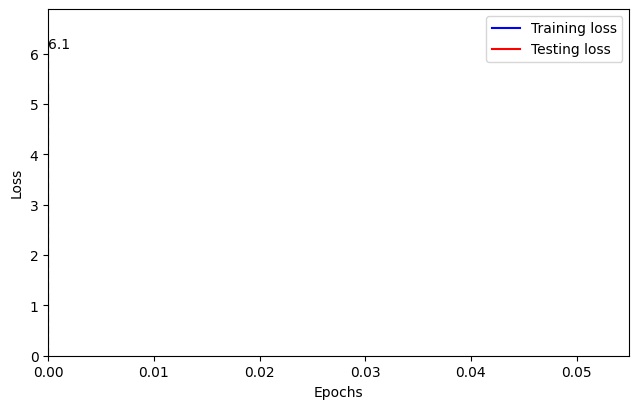

Traing epoch: 1   avg loss is: 3.8858446109429488
Testing epoch: 1   avg testing loss is: 5.5480410935968845
Testing on epoch: 1 has accuracy: top1: 19.37 top5: 38.30


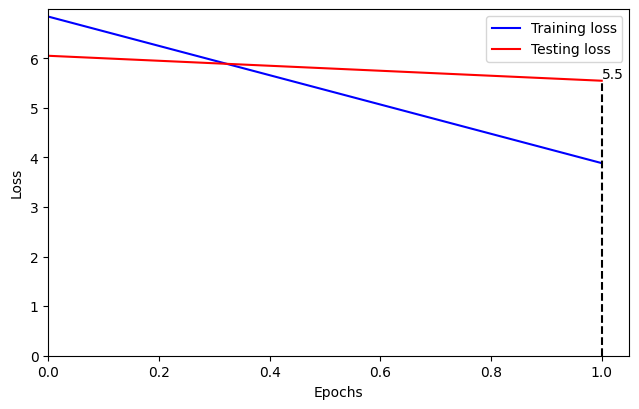

Traing epoch: 2   avg loss is: 3.1308966679546866
Testing epoch: 2   avg testing loss is: 5.122003260922597
Testing on epoch: 2 has accuracy: top1: 28.73 top5: 48.59


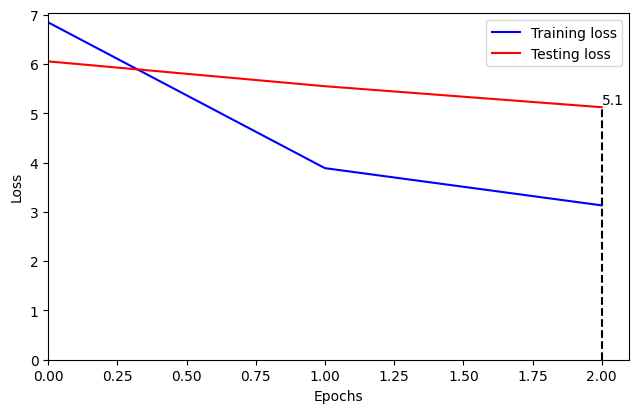

Traing epoch: 3   avg loss is: 2.7429093422233457
Testing epoch: 3   avg testing loss is: 4.796908978898199
Testing on epoch: 3 has accuracy: top1: 32.40 top5: 52.57


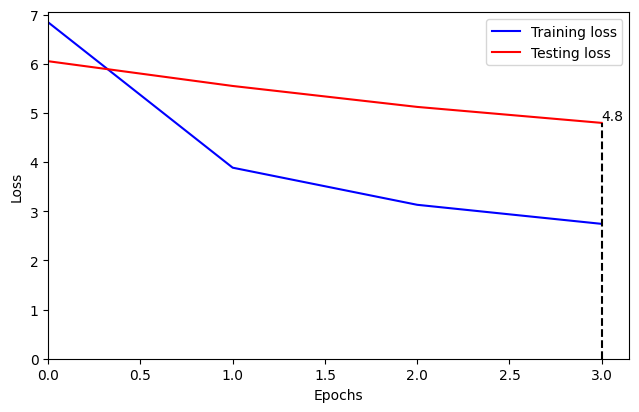

Traing epoch: 4   avg loss is: 2.475431334364876
Testing epoch: 4   avg testing loss is: 4.583638366960096
Testing on epoch: 4 has accuracy: top1: 35.26 top5: 55.21


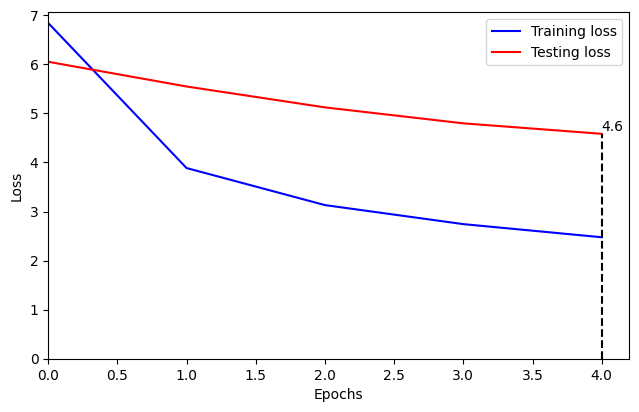

Traing epoch: 5   avg loss is: 2.274289839181152
Testing epoch: 5   avg testing loss is: 4.380690517928005
Testing on epoch: 5 has accuracy: top1: 37.07 top5: 57.98


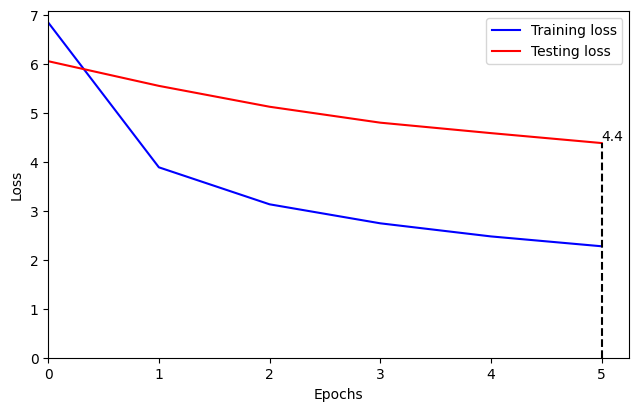

Traing epoch: 6   avg loss is: 2.1181098544674017
Testing epoch: 6   avg testing loss is: 4.465348687306435
Testing on epoch: 6 has accuracy: top1: 38.05 top5: 56.50


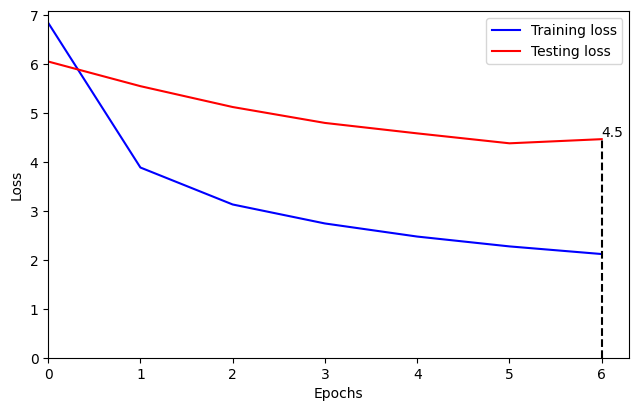

Traing epoch: 7   avg loss is: 1.9917990693349026
Testing epoch: 7   avg testing loss is: 4.303951198969704
Testing on epoch: 7 has accuracy: top1: 38.94 top5: 58.71


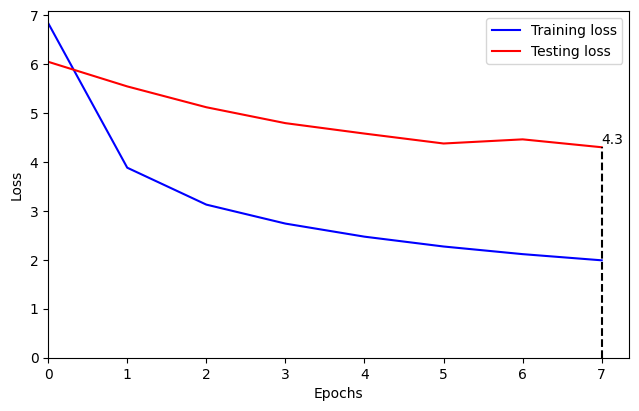

Traing epoch: 8   avg loss is: 1.8897994245775669
Testing epoch: 8   avg testing loss is: 4.175593830030481
Testing on epoch: 8 has accuracy: top1: 40.42 top5: 59.46


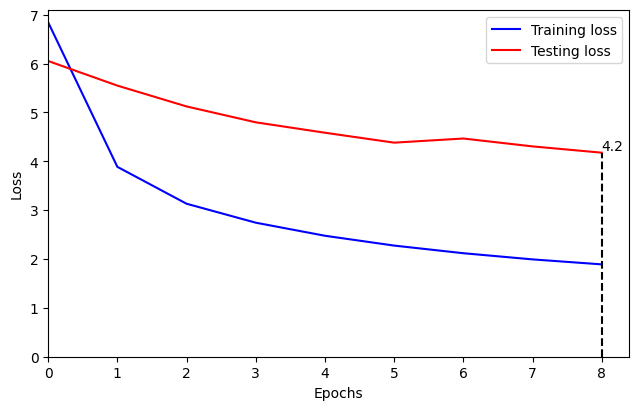

Traing epoch: 9   avg loss is: 1.80102123872587
Testing epoch: 9   avg testing loss is: 4.094826038496618
Testing on epoch: 9 has accuracy: top1: 40.97 top5: 60.59


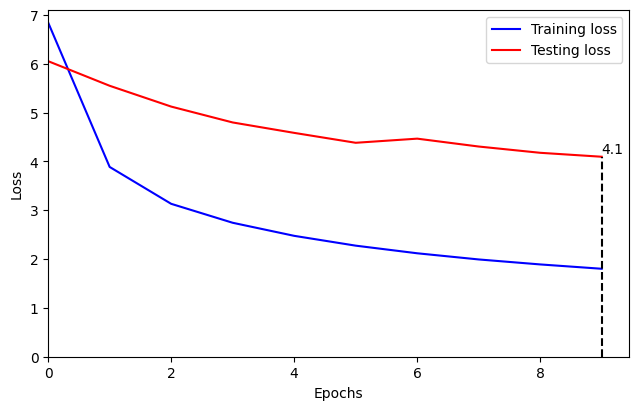

Traing epoch: 10   avg loss is: 1.5709239923084586
Testing epoch: 10   avg testing loss is: 3.8285707104643842
Testing on epoch: 10 has accuracy: top1: 45.42 top5: 63.87


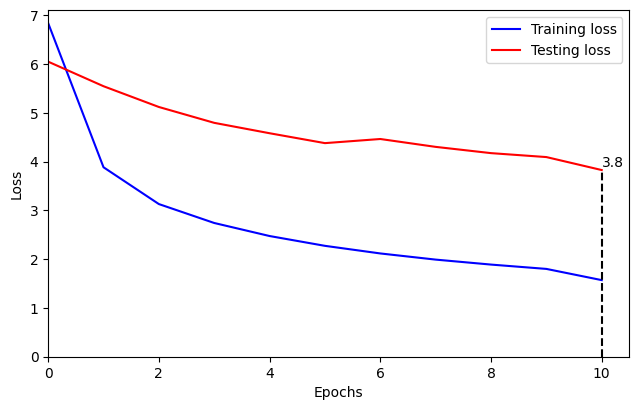

Traing epoch: 11   avg loss is: 1.506279279754989
Testing epoch: 11   avg testing loss is: 3.7410180649902034
Testing on epoch: 11 has accuracy: top1: 46.19 top5: 64.73


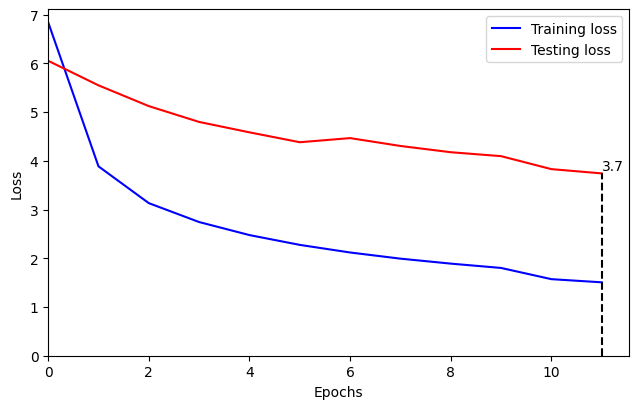

Traing epoch: 12   avg loss is: 1.465083285188544
Testing epoch: 12   avg testing loss is: 3.774511421151844
Testing on epoch: 12 has accuracy: top1: 45.97 top5: 63.96


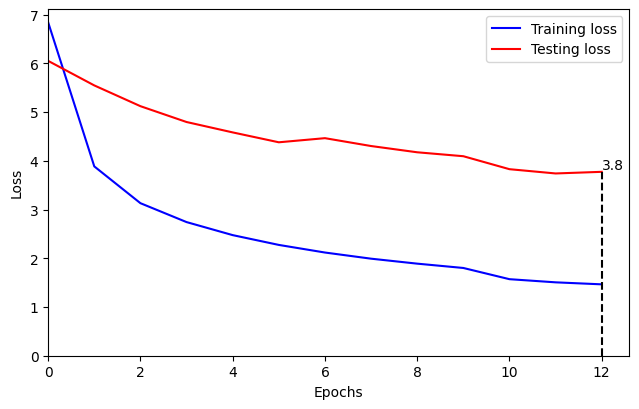

Traing epoch: 13   avg loss is: 1.431255966124827
Testing epoch: 13   avg testing loss is: 3.6794602610190665
Testing on epoch: 13 has accuracy: top1: 47.22 top5: 65.15


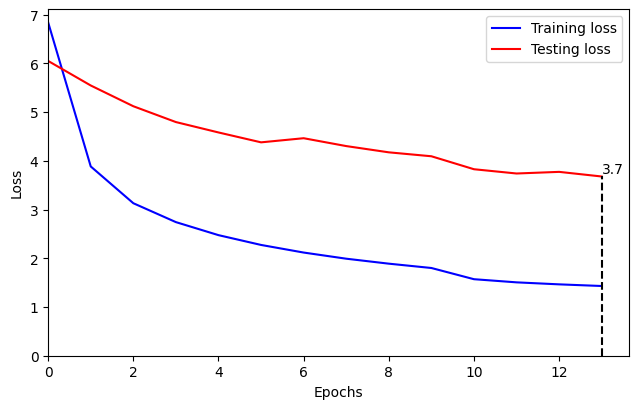

Traing epoch: 14   avg loss is: 1.3988357762538117
Testing epoch: 14   avg testing loss is: 3.7359373467979817
Testing on epoch: 14 has accuracy: top1: 46.29 top5: 63.70


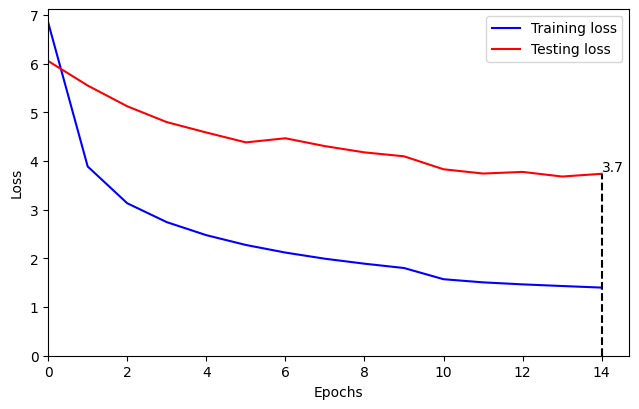

Traing epoch: 15   avg loss is: 1.373329172383222
Testing epoch: 15   avg testing loss is: 3.7114455536237863
Testing on epoch: 15 has accuracy: top1: 45.72 top5: 64.00


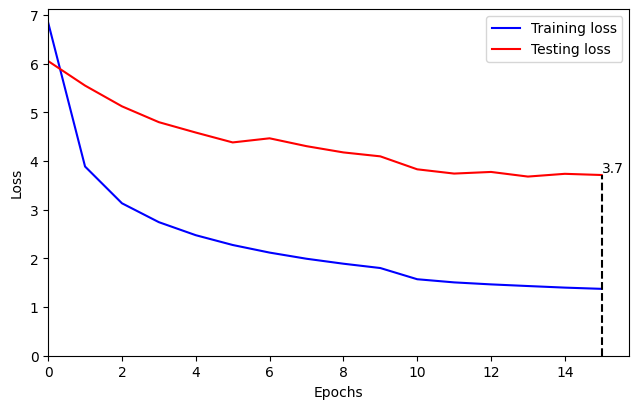

Traing epoch: 16   avg loss is: 1.3518429726298569
Testing epoch: 16   avg testing loss is: 3.650556307640908
Testing on epoch: 16 has accuracy: top1: 47.37 top5: 64.91


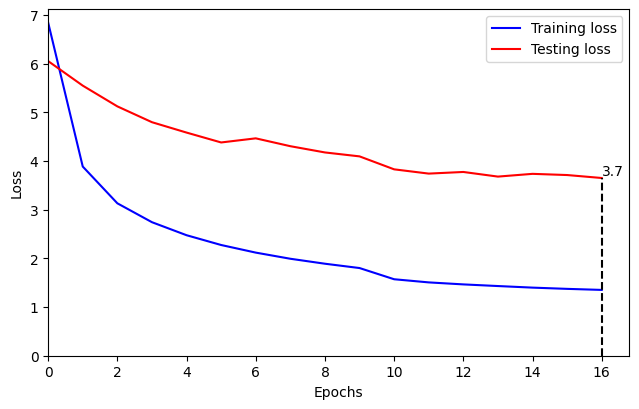

Traing epoch: 17   avg loss is: 1.3325805616589774
Testing epoch: 17   avg testing loss is: 3.642868808002279
Testing on epoch: 17 has accuracy: top1: 47.17 top5: 65.12


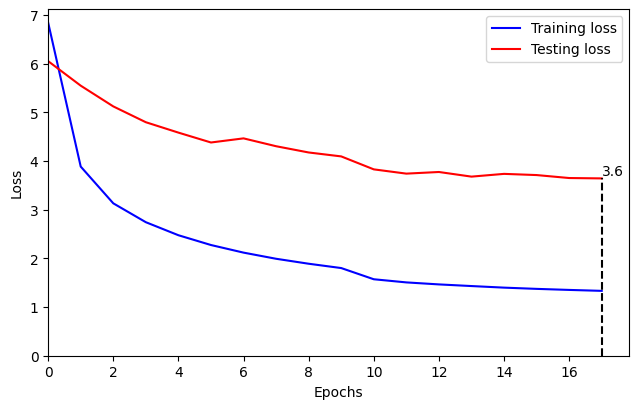

Traing epoch: 18   avg loss is: 1.3126565669599306
Testing epoch: 18   avg testing loss is: 3.672697532678171
Testing on epoch: 18 has accuracy: top1: 47.03 top5: 64.22


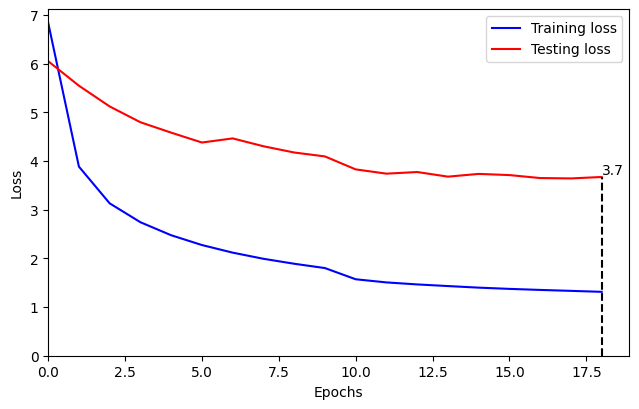

Traing epoch: 19   avg loss is: 1.297734264433293
Testing epoch: 19   avg testing loss is: 3.643793619332509
Testing on epoch: 19 has accuracy: top1: 46.77 top5: 64.42


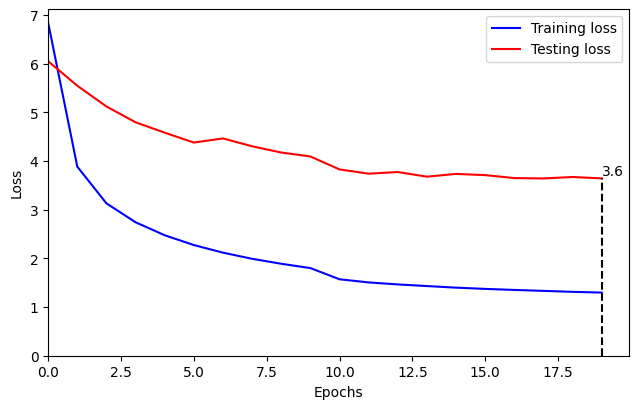

Traing epoch: 20   avg loss is: 1.2292480070233744
Testing epoch: 20   avg testing loss is: 3.5224510969285827
Testing on epoch: 20 has accuracy: top1: 48.95 top5: 66.11


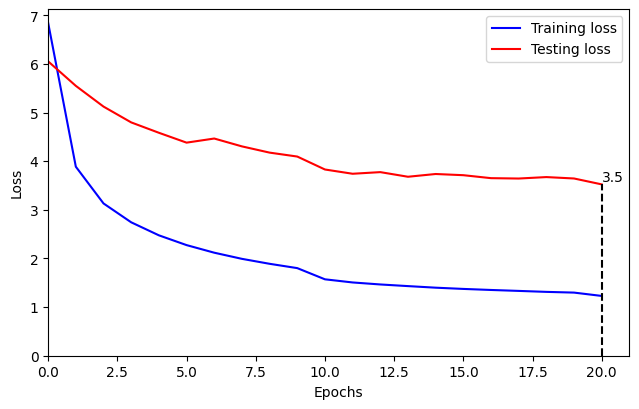

Traing epoch: 21   avg loss is: 1.213050906346053
Testing epoch: 21   avg testing loss is: 3.5255010438257233
Testing on epoch: 21 has accuracy: top1: 49.37 top5: 65.95


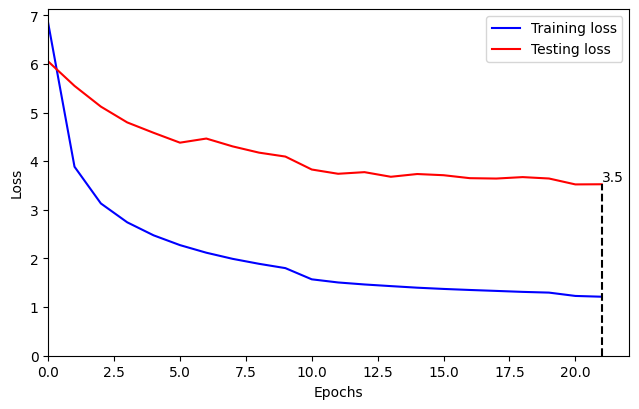

Traing epoch: 22   avg loss is: 1.2035214865866106
Testing epoch: 22   avg testing loss is: 3.5295665644787295
Testing on epoch: 22 has accuracy: top1: 49.45 top5: 66.17


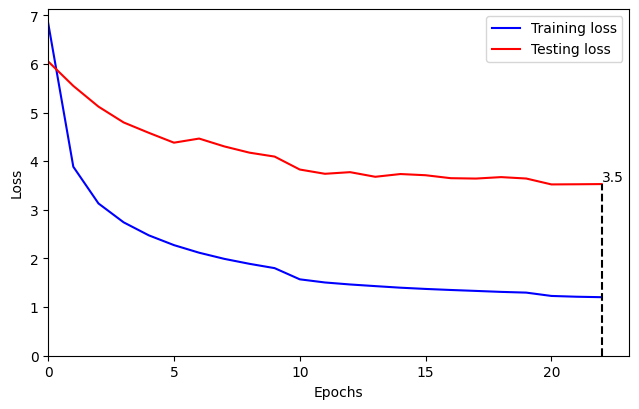

Traing epoch: 23   avg loss is: 1.1959580931861407
Testing epoch: 23   avg testing loss is: 3.5553254907343095
Testing on epoch: 23 has accuracy: top1: 48.58 top5: 65.31


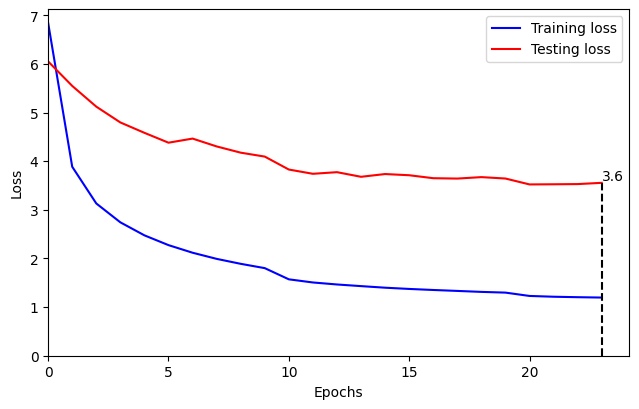

Traing epoch: 24   avg loss is: 1.1893045802577662
Testing epoch: 24   avg testing loss is: 3.5394929706447615
Testing on epoch: 24 has accuracy: top1: 48.61 top5: 65.44


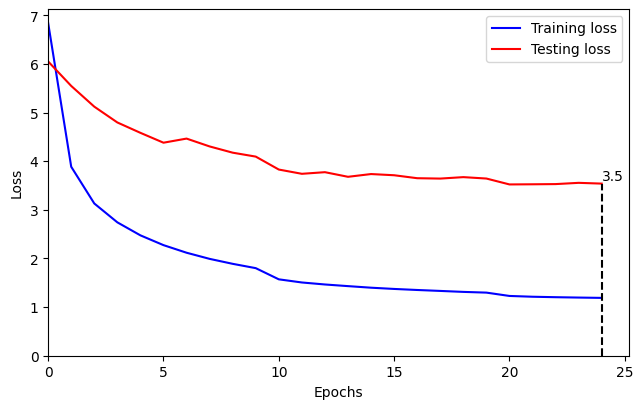

Traing epoch: 25   avg loss is: 1.1822252466724454
Testing epoch: 25   avg testing loss is: 3.5092752232330793
Testing on epoch: 25 has accuracy: top1: 49.19 top5: 65.95


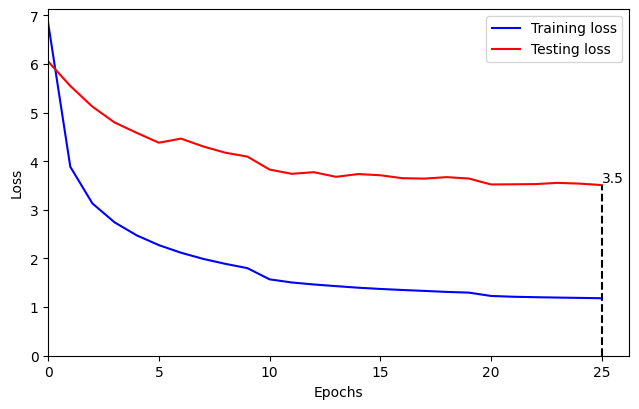

Traing epoch: 26   avg loss is: 1.1769577347362845
Testing epoch: 26   avg testing loss is: 3.5395494780050685
Testing on epoch: 26 has accuracy: top1: 49.32 top5: 65.63


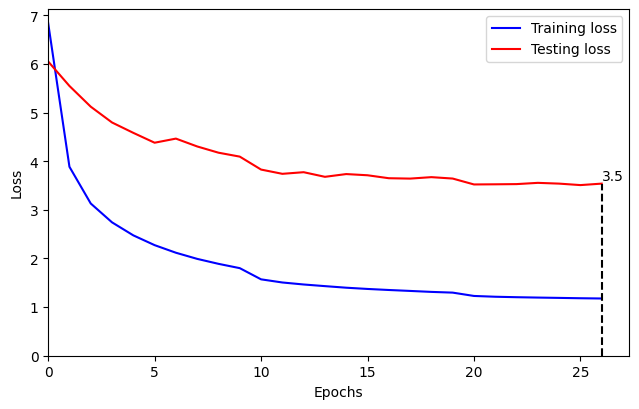

Traing epoch: 27   avg loss is: 1.1720953434751207
Testing epoch: 27   avg testing loss is: 3.5235070510390214
Testing on epoch: 27 has accuracy: top1: 49.00 top5: 65.54


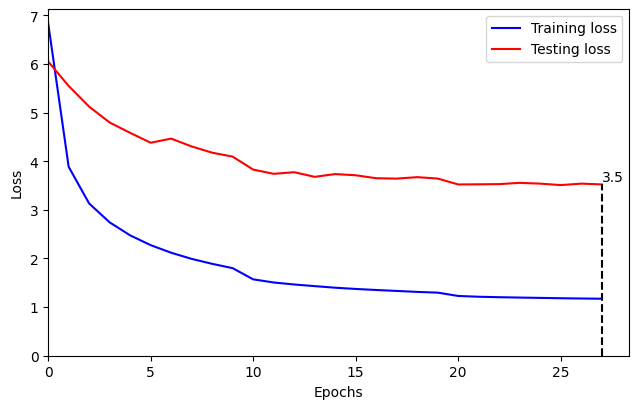

Traing epoch: 28   avg loss is: 1.1677838211966098
Testing epoch: 28   avg testing loss is: 3.5589077820988524
Testing on epoch: 28 has accuracy: top1: 48.54 top5: 65.18


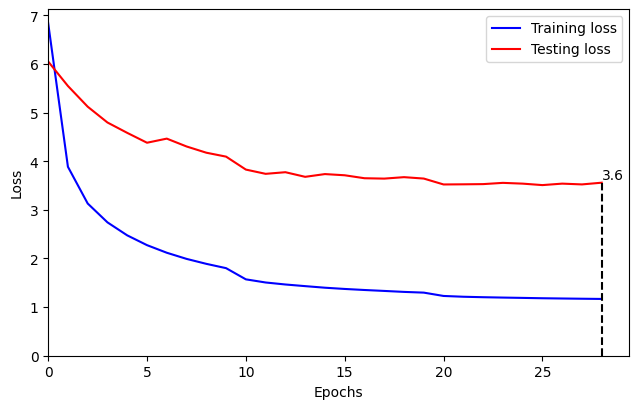

Traing epoch: 29   avg loss is: 1.1625250221608359
Testing epoch: 29   avg testing loss is: 3.5364527853325747
Testing on epoch: 29 has accuracy: top1: 48.80 top5: 65.26


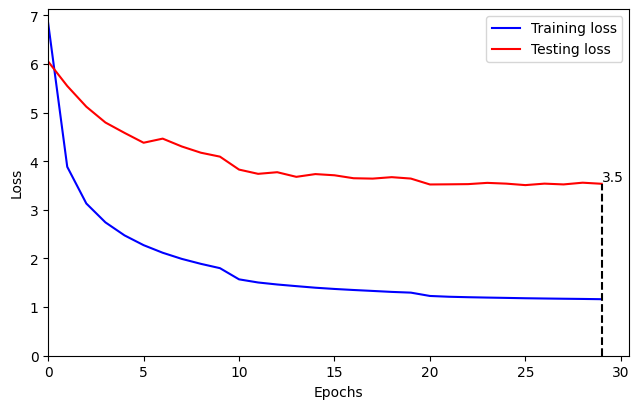

Traing epoch: 30   avg loss is: 1.1401591193286755
Testing epoch: 30   avg testing loss is: 3.4756551376361045
Testing on epoch: 30 has accuracy: top1: 50.16 top5: 66.22


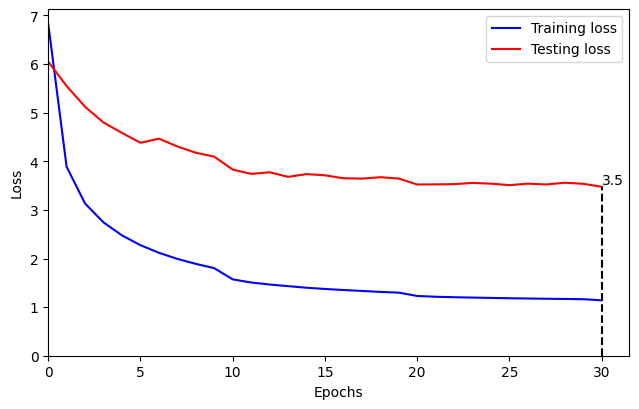

Traing epoch: 31   avg loss is: 1.1343038039197273
Testing epoch: 31   avg testing loss is: 3.4798033427151673
Testing on epoch: 31 has accuracy: top1: 50.06 top5: 66.28


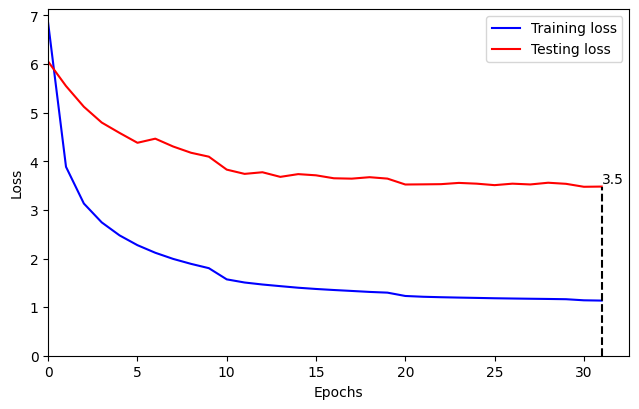

Traing epoch: 32   avg loss is: 1.1304211346230786
Testing epoch: 32   avg testing loss is: 3.495149188564457
Testing on epoch: 32 has accuracy: top1: 49.94 top5: 66.11


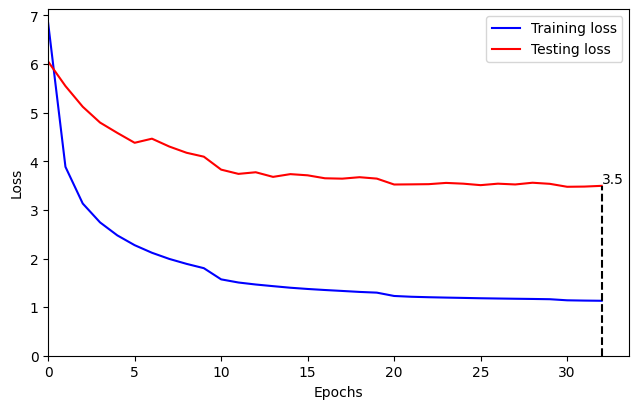

Traing epoch: 33   avg loss is: 1.1279173038665717
Testing epoch: 33   avg testing loss is: 3.481854809605739
Testing on epoch: 33 has accuracy: top1: 50.53 top5: 66.53


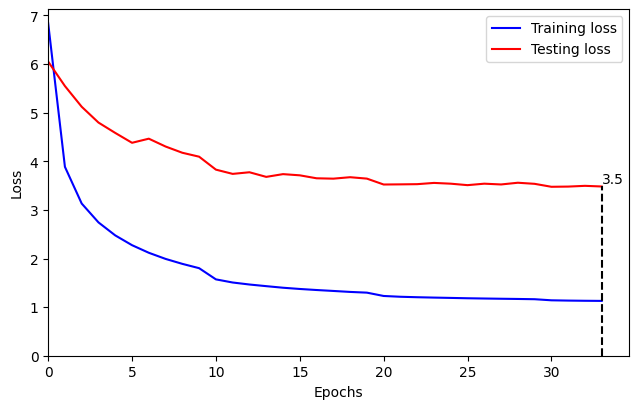

Traing epoch: 34   avg loss is: 1.125221845959613
Testing epoch: 34   avg testing loss is: 3.4910051351915716
Testing on epoch: 34 has accuracy: top1: 50.26 top5: 66.38


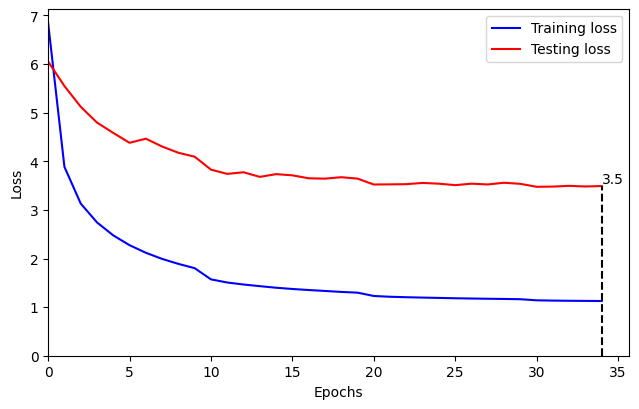

In [4]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png',mode='vertical'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        self.train_folder = self.folder+'/train/'
        destination_dir = "/kaggle/working/train/"
        shutil.copytree(self.train_folder, destination_dir)
        #output_dir = "/kaggle/working/train/"
        image_transformer = ImageTransformer(destination_dir)
        image_transformer.process_and_save_images()
        self.test_folder = self.folder+'/test/'

        self.imgtype=imgtype
        self.mode = mode
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        #basedir = 'GRRNN_WriterIdentification_dataset_'+self.dataset+'_model_'+self.mode+'_aug_16'
        basedir = 'GRRNN_WriterIdentification_dataset_ICDAR_model_'+self.mode+'_aug_16'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=destination_dir,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)

    def train(self,epoch):
        self.model.train()
        losstotal = []

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)


            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()


        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))

        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []


        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)


        top1 /= float(ntotal)
        top5 /= float(ntotal)

        print('Testing epoch:',epoch,'  avg testing loss is:',np.mean(losstotal))
        print('Testing on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        with open(self.logfile,'a') as fp:
            fp.write('Testing epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)



    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')

    def plot_losses(self, training_losses, testing_losses):
        indices = range(len(training_losses))
        plt.figure(figsize=(7.5, 4.5))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Testing loss')
        #plt.title('Training and Testing Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)
        plt.show()

    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):
            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res


if __name__ == '__main__':

    modelist = ['vertical','horizontal']
    mode = modelist[1]

    mod = DeepWriter_Train(dataset='/kaggle/input/icdar17-widewords/ICDAR17_lsegs',mode=mode)
    mod.train_loops(0,35)